#Introduction

BDSCAN (Boundary-Region-Based Density-Scalable Clustering Algorithm) is an unsupervised machine learning algorithm that makes clusters based upon the density of the data points or how close the data is.


BDSCAN characterizes the data points as core, border, or noise points based on their density and spatial distribution.
For each instance, the algorithm counts how many instances are located within a small distance ε (epsilon) from it. This region is called the instance’s ε- neighborhood. If an instance has at least min_samples instances in its ε-neighborhood (including itself), then it is considered a core instance. In other words, core instances are those that are located in dense regions. All instances in the neighborhood of a core instance belong to the same cluster. This may include other core instances, therefore a long sequence of neighboring core instances forms a single cluster.
Any instance that is not a core instance and does not have one in its neighborhood is considered an anomaly.


the algorithm utilizes two user-defined parameters: the minimum density parameter (min_points) and the neighborhood radius (epsilon). By dynamically adjusting these parameters, BDSCAN can effectively identify clusters of different sizes and shapes while minimizing the influence of noise in the clustering process.



To construct a DBSCAN algorithm from scratch, the program will execute the following steps:

1- Choose a value for epsilon and min_points

2- For a particular data point (x) calculate its distance from every other datapoint.

3- Find all the neighbourhood points of x which fall inside the circle of radius (epsilon) or simply whose distance from x is smaller than or equal to eps.

4- Treat x as visited and if the number of neighbourhood points around x are greater or equal to min_points then treat x as a core point and if it is not assigned to any cluster, create a new cluster and assign it to that.

5 - If the number of neighbourhood points around x are less than min_points and it has a core point in its neighbourhood, treat it as a border point.

6- Include all the density connected points as a single cluster. (What density connected points mean is described later)

7- Repeat the above steps for every unvisited point in the data set and find out all core, border and outlier points.



In this post, we compare the built-in code with DBSCAN from scikit-learn using the Iris and make_moons datasets. We analyze the outputs by adjusting the epsilon and minimum density parameters.


### References:

https://towardsdatascience.com/dbscan-make-density-based-clusters-by-hand-2689dc335120

https://scrunts23.medium.com/dbscan-algorithm-from-scratch-in-python-475b82e0571c




In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import RobustScaler
from sklearn.datasets import make_moons


In [2]:
class DBSCANAlgo:

    def __init__(self, data, min_points,epsilon=None,normalize_data=True):
        self.data = data
        self.epsilon = epsilon  # neighborhood radius
        self.min_points = min_points  # minimum neighbors for cluster point
        self._cluster_num = 1  # running cluster number
        self.classification = np.zeros(len(data))-1 # Initialize classification for data points (-1 indicates unclassified)

        if normalize_data:
           self._normalize_data()


        # Calculate the pairwise distance matrix using Euclidean distance
        self.distance_matrix = np.linalg.norm(data[np.newaxis, ...] - data[:, np.newaxis, :], axis=-1)
        # Set diagonal elements to infinity
        #setting the diagonal elements to infinity ensures that a point's distance to itself is effectively ignored when identifying its neighbors.
        self.distance_matrix += np.diag([np.inf] * len(data))

        if epsilon == None:
            self._set_default_epsilon()


    def _normalize_data(self):
        self.data = RobustScaler().fit_transform(self.data)

    # Set a default value for epsilon based on the distance matrix
    def _set_default_epsilon(self):
        self.epsilon = 4*np.median(self.distance_matrix)


    #Find indices of points close to index_point within epsilon distance
    def _region_query(self,index_point):
        neighbors = np.nonzero(self.distance_matrix[index_point, :] <= self.epsilon)
        return neighbors[0]


    # Expand a cluster starting from a core point
    def _expand_cluster(self,core):
        self.classification[core] = self._cluster_num # Assign the cluster number to the core point
        neighbour_pts_indices = self._region_query(core)  # list of un-clustered neighbors
        while len(neighbour_pts_indices):
            next_gen = []
            for i in neighbour_pts_indices:
                self.classification[i] = self._cluster_num  # give a classification to all neighbors

                # if a neighbor is a cluster point, add all his neighbors to the cluster
                sub_neighbours_indices = self._region_query(i)
                if len(sub_neighbours_indices) >= self.min_points:  #check if is core point
                    to_next_gen = sub_neighbours_indices[self.classification[sub_neighbours_indices]==-1]
                    next_gen.extend(to_next_gen.tolist())
            neighbour_pts_indices = next_gen[:]  # Move to next generation




    ## Visualize clusters using scatter plot
    def show_clusters(data,classification,first=0,second=1,title=''):  # input - axis column x and y
        x_axis = data[:, first]
        y_axis = data[:, second]
        plt.figure()
        plt.scatter(x_axis[classification == -1], y_axis[classification == -1],
                    label="Noise", alpha=0.5, c='lightblue')
        plt.scatter(x_axis[classification != -1], y_axis[classification != -1],
                    c=classification[classification != -1], label='clusters')
        plt.legend()
        plt.xlabel('first')
        plt.ylabel('second')
        plt.title(title)
        plt.show()


    # Main function running on all data points to perform DBSCAN clustering
    def fit(self):
        for i in range(len(self.data)):
            if self.classification[i] == -1 and len(self._region_query(i)) >= self.min_points:  # new cluster point
                # If the point is unclassified and qualifies as a core point, expand the cluster
                self._expand_cluster(i)
                self._cluster_num += 1  # increase number for next cluster



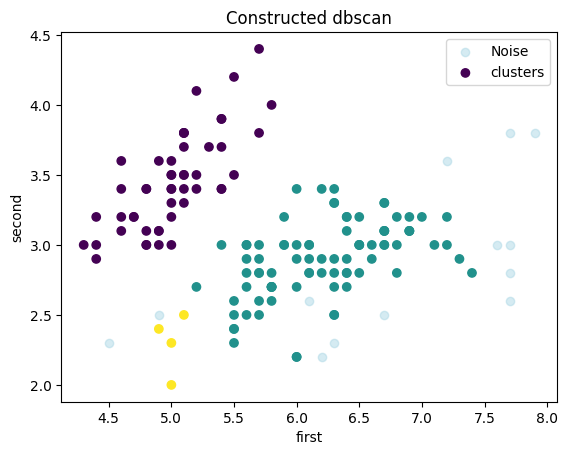

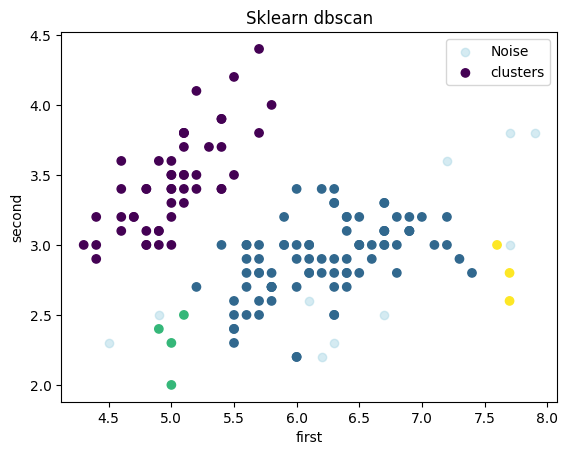

In [13]:
if __name__ == '__main__':
    data = load_iris()
    epsilon = 0.5
    min_points = 3

    dbscan_obj = DBSCANAlgo(data.data,min_points,epsilon)
    dbscan_obj.fit()
    DBSCANAlgo.show_clusters(data.data, dbscan_obj.classification, 0, 1, 'Constructed dbscan')

    sklearn_obj = DBSCAN(eps=epsilon, min_samples=min_points)
    sklearn_obj.fit(data.data)
    DBSCANAlgo.show_clusters(data.data, sklearn_obj.labels_, 0, 1, 'Sklearn dbscan')


The true values of the flowers are:

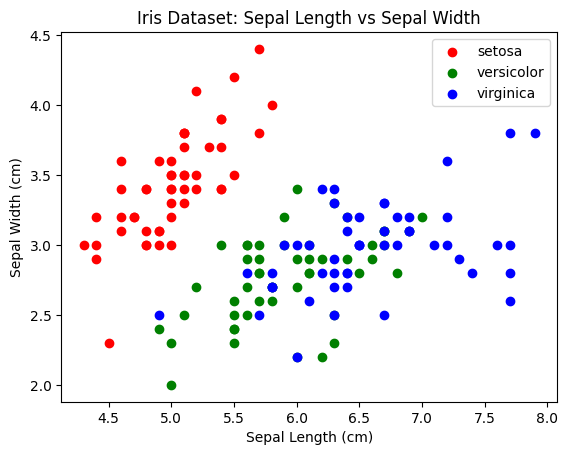

In [20]:
# Load Iris dataset
iris = load_iris()
data = iris['data']
target = iris['target']

# Define colors for each species
colors = ['red', 'green', 'blue']

# Plot Sepal Length vs Sepal Width for all three species
for i in range(3):
    species_data = data[target == i]
    plt.scatter(species_data[:, 0], species_data[:, 1], c=colors[i], label=iris['target_names'][i])

plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.title('Iris Dataset: Sepal Length vs Sepal Width')

plt.legend()
plt.show()

The results from utilizing DBSCAN indicate a close similarity between the obtained outcomes using both methods. In both scenarios, the algorithm proves effective in distinguishing the setosa flower from the other two species.



Now, lets use make_moons data set to explore the algorithm parameters.

In [6]:
X, _ = make_moons(n_samples=150, noise=0.05)  # Generate make_moons dataset
data_for_dbscan = np.column_stack((X[:, 0], X[:, 1]))

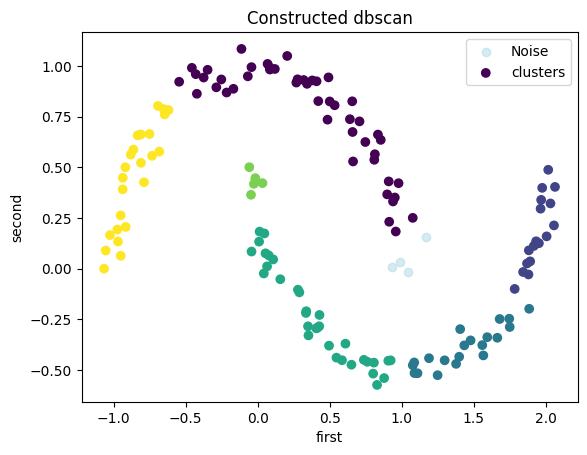

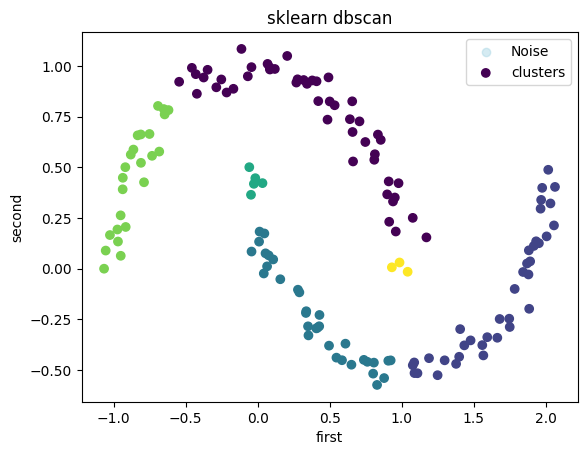

In [24]:
if __name__ == '__main__':
    data = data_for_dbscan
    epsilon = 0.15
    min_points = 3

    dbscan_obj = DBSCANAlgo(data, min_points, epsilon)
    #dbscan_obj = DBSCANAlgo(data_for_dbsca , min_points, epsilon)
    dbscan_obj.fit()
    DBSCANAlgo.show_clusters(data, dbscan_obj.classification, 0, 1, 'Constructed dbscan')
    #DBSCANAlgo.show_clusters(data.data, dbscan_obj.classification, 0, 1, 'constructed dbscan')

    sklearn_obj = DBSCAN(eps=epsilon, min_samples=min_points)
    sklearn_obj.fit(data)
    DBSCANAlgo.show_clusters(data, sklearn_obj.labels_, 0, 1, 'sklearn dbscan')

When employing epsilon = 0.15 and min_points = 3, both methods generate six distinct clusters.

What occurs if we increase epsilon while keeping the min_points values constant?



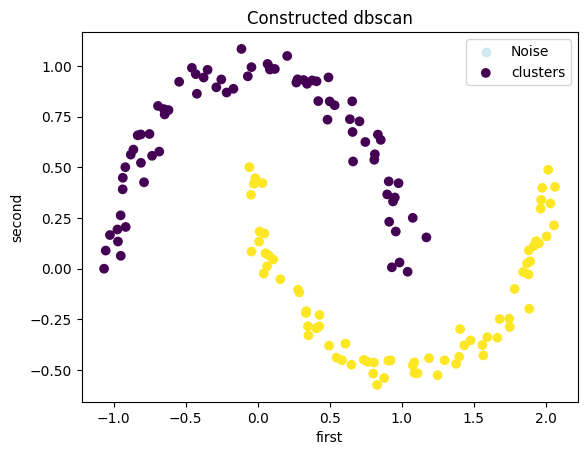

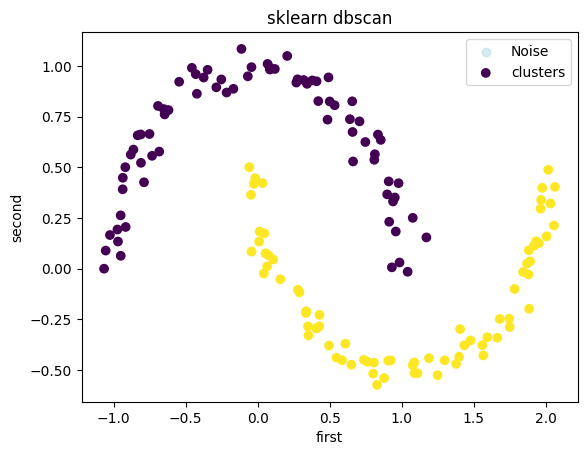

In [23]:
if __name__ == '__main__':
    data = data_for_dbscan
    epsilon = 0.4
    min_points = 3

    dbscan_obj = DBSCANAlgo(data, min_points, epsilon)
    #dbscan_obj = DBSCANAlgo(data_for_dbsca , min_points, epsilon)
    dbscan_obj.fit()
    DBSCANAlgo.show_clusters(data, dbscan_obj.classification, 0, 1, 'Constructed dbscan')
    #DBSCANAlgo.show_clusters(data.data, dbscan_obj.classification, 0, 1, 'constructed dbscan')

    sklearn_obj = DBSCAN(eps=epsilon, min_samples=min_points)
    sklearn_obj.fit(data)
    DBSCANAlgo.show_clusters(data, sklearn_obj.labels_, 0, 1, 'sklearn dbscan')

Expanding epsilon causes the algorithm to widen the neighborhood radius, resulting in the formation of larger clusters. Consequently, the total number of clusters decreases.

Now, let's increase the value of min_points to 6 while maintaining epsilon at 0.15.

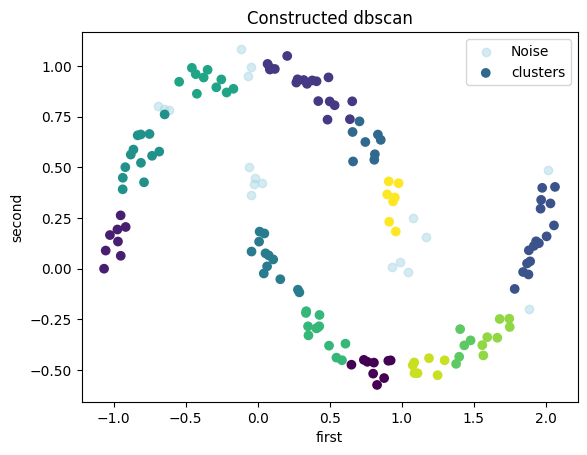

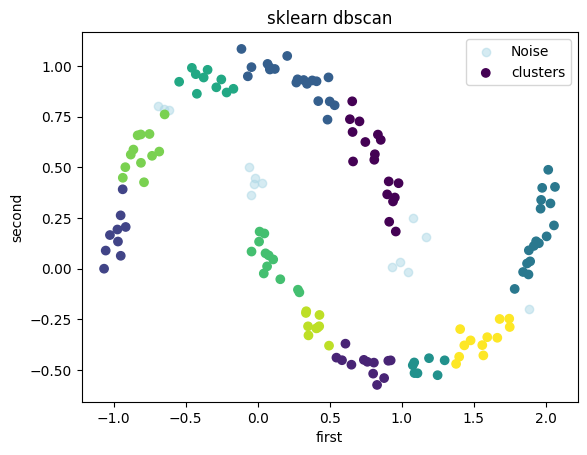

In [25]:
if __name__ == '__main__':
    data = data_for_dbscan
    epsilon = 0.15
    min_points = 6

    dbscan_obj = DBSCANAlgo(data, min_points, epsilon)
    #dbscan_obj = DBSCANAlgo(data_for_dbsca , min_points, epsilon)
    dbscan_obj.fit()
    DBSCANAlgo.show_clusters(data, dbscan_obj.classification, 0, 1, 'Constructed dbscan')
    #DBSCANAlgo.show_clusters(data.data, dbscan_obj.classification, 0, 1, 'constructed dbscan')

    sklearn_obj = DBSCAN(eps=epsilon, min_samples=min_points)
    sklearn_obj.fit(data)
    DBSCANAlgo.show_clusters(data, sklearn_obj.labels_, 0, 1, 'sklearn dbscan')

Increasing the value of Min_points prompts the algorithm to require a higher density of points within the specified neighborhood to form a cluster. As a consequence, we observe an increase in the number of clusters due to the algorithm's heightened selectivity in identifying them. However, this adjustment also leads to a greater count of outliers.